
... ***CURRENTLY UNDER DEVELOPMENT*** ...


## HyCReeW-Q : Overtopping estimation of historical nearshore storms at 3 locations

inputs required: 
  * Historical DWTs
  * MU - TAU intradaily hidrographs time series
  * Historical water levels

in this notebook:
  * Transform storms into hourly time series
  * HyCReWW-Q overtopping estimation of historical events
  


## Database and Site parameters

In [1]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-

# common
import os
import os.path as op

# pip
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
from datetime import datetime

# DEV: override installed teslakit
import sys
sys.path.insert(0, op.join(os.path.abspath(''), '..', '..', '..'))

# teslakit
from teslakit.database import Database
from teslakit.rbf import RBF_Interpolation
from teslakit.mda import Normalize

from teslakit.util.time_operations import npdt64todatetime, fast_reindex_hourly, repair_times_hourly, add_max_storms_mask
   


In [2]:
# --------------------------------------
# Teslakit database

p_data = r'/Users/albacid/Projects/TeslaKit_projects'
db = Database(p_data)

# set site
db.SetSite('KWAJALEIN')


# --------------------------------------
# N, S, E profiles
pN = 28 #(36,22)
pS = 8  #(13,1)
pE = 16 #(21,14)
#pN = 35 #28 #(36,22)
#pS = 4  #8  #(13,1)
#pE = 20 #16 #(21,14)


# --------------------------------------
# Load historical TWL
hist_TWL = xr.open_dataset(op.join(p_data, 'sites/KWAJALEIN/TIDE/hist_TWL.nc'))


# --------------------------------------
# load Hycreww RBF coefficients and sim. variables min. and max.
var_lims, rbf_coeffs = db.Load_HYCREWW_Q()


# reef characteristics (AlbaR)
xds = xr.open_dataset(op.join(p_data, 'inputs_Kwajalein','datos_perfiles_albaR','data_profiles.nc'))
xds = xds.drop('zBeach')
reef_N = xds.sel(profile = pN )
reef_S = xds.sel(profile = pS)
reef_E = xds.sel(profile = pE)


# Zbeach characteristics (Sara)
#xds_Zbeach = xr.open_dataset(op.join(p_data, 'inputs_Kwajalein','datos_perfiles_sara','zBeach_clean_P1.nc'))
xds_Zbeach = xr.open_dataset(op.join(p_data, 'inputs_Kwajalein','datos_perfiles_sara','zBeach_perimeter1.nc'))
xds_Zbeach = xds_Zbeach.drop({'xcoor', 'ycoor'})

Zbeach_N = xds_Zbeach.sel(profile = pN )
Zbeach_S = xds_Zbeach.sel(profile = pS)
Zbeach_E = xds_Zbeach.sel(profile = pE)

print(Zbeach_N.zBeach)
print(Zbeach_S.zBeach)
print(Zbeach_E.zBeach)


# --------------------------------------
# Load nearshore waves
WAVES_N = xr.open_dataset(op.join(p_data, 'sites/KWAJALEIN/WAVES/swells_profiles_N.nc')) # hourly
WAVES_S = xr.open_dataset(op.join(p_data, 'sites/KWAJALEIN/WAVES/swells_profiles_S.nc')) # 3-hourly
WAVES_E = xr.open_dataset(op.join(p_data, 'sites/KWAJALEIN/WAVES/swells_profiles_E.nc')) # 3-hourly


# to hourly and same dates
WAVES_N = WAVES_N.sel(time=slice(WAVES_S.time.values[0], WAVES_S.time.values[-1]))
WAVES_S = WAVES_S.resample(time='1H').interpolate('linear')
WAVES_E = WAVES_E.resample(time='1H').interpolate('linear')

WAVES_N = WAVES_N.sel(profile = pN )
WAVES_S = WAVES_S.sel(profile = pS)
WAVES_E = WAVES_E.sel(profile = pE)

print(WAVES_N)
print(WAVES_S)
print(WAVES_E)

<xarray.DataArray 'zBeach' ()>
array(1.473809)
Coordinates:
    profile  int64 28
<xarray.DataArray 'zBeach' ()>
array(1.533132)
Coordinates:
    profile  int64 8
<xarray.DataArray 'zBeach' ()>
array(1.182817)
Coordinates:
    profile  int64 16
<xarray.Dataset>
Dimensions:  (time: 359401)
Coordinates:
  * time     (time) datetime64[ns] 1979-01-01 1979-01-01T01:00:00 ... 2020-01-01
    profile  float64 28.0
Data variables:
    hs       (time) float64 ...
    tp       (time) float64 ...
    dir      (time) float64 ...
<xarray.Dataset>
Dimensions:      (time: 359401)
Coordinates:
    profile      float64 8.0
  * time         (time) datetime64[ns] 1979-01-01 ... 2020-01-01
Data variables:
    hs           (time) float64 0.0 0.1717 0.3434 0.5151 ... 1.806 1.832 1.857
    tm           (time) float64 nan nan nan nan ... 10.91 11.35 11.79 12.23
    tp           (time) float64 nan nan nan nan ... 13.85 14.51 15.16 15.81
    dirP         (time) float64 nan nan nan nan ... 230.7 230.8 230.9 231.0


## Hycreww RBF Interpolation

##### Set parameters for Hycreww: TWL, Reef Slope, Beach Slope, Reef Width, Zbeach, Cf

In [3]:

dset_N = xr.Dataset(
            {   'hs':(('time'), WAVES_N.hs.values),
                'tp':(('time'), WAVES_N.tp.values),
                'bslope':(('time'), np.ones(len(WAVES_N.time),)*reef_N['Beach Slope'].values),
                'rslope':(('time'), np.ones(len(WAVES_N.time),)*reef_N['Fore Slope'].values),
                'rwidth':(('time'), np.ones(len(WAVES_N.time),)*reef_N['Wreef'].values),
                'Zb':(('time'), np.ones(len(WAVES_N.time),)*Zbeach_N['zBeach'].values),
                'cf':(('time'), np.ones(len(WAVES_N.time),)*0.1),
            },coords = {'time': WAVES_N.time.values})

dset_S = xr.Dataset(
            {   'hs':(('time'), WAVES_S.hs.values),
                'tp':(('time'), WAVES_S.tp.values),
                'bslope':(('time'), np.ones(len(WAVES_S.time),)*reef_S['Beach Slope'].values),
                'rslope':(('time'), np.ones(len(WAVES_S.time),)*reef_S['Fore Slope'].values),
                'rwidth':(('time'), np.ones(len(WAVES_S.time),)*reef_S['Wreef'].values),
                'Zb':(('time'), np.ones(len(WAVES_S.time),)*Zbeach_S['zBeach'].values),
                'cf':(('time'), np.ones(len(WAVES_S.time),)*0.1),
            },coords = {'time': WAVES_S.time.values})

dset_E = xr.Dataset(
            {   'hs':(('time'), WAVES_E.hs.values),
                'tp':(('time'), WAVES_E.tp.values),
                'bslope':(('time'), np.ones(len(WAVES_E.time),)*reef_E['Beach Slope'].values),
                'rslope':(('time'), np.ones(len(WAVES_E.time),)*reef_E['Fore Slope'].values),
                'rwidth':(('time'), np.ones(len(WAVES_E.time),)*reef_E['Wreef'].values),
                'Zb':(('time'), np.ones(len(WAVES_E.time),)*Zbeach_E['zBeach'].values),
                'cf':(('time'), np.ones(len(WAVES_E.time),)*0.1),
            },coords = {'time': WAVES_E.time.values})

dset_N = dset_N.sel(time=slice(dset_N.time.values[0],hist_TWL.time.values[-1]))
dset_S = dset_S.sel(time=slice(dset_N.time.values[0],hist_TWL.time.values[-1]))
dset_E = dset_E.sel(time=slice(dset_N.time.values[0],hist_TWL.time.values[-1]))

dset_N['level'] = hist_TWL.TWL.sel(time=dset_N.time)
dset_S['level'] = hist_TWL.TWL.sel(time=dset_S.time)
dset_E['level'] = hist_TWL.TWL.sel(time=dset_E.time)

dset_N['hs_lo2'] = (dset_N.hs/(1.5613*dset_N.tp**2))
dset_S['hs_lo2'] = (dset_S.hs/(1.5613*dset_S.tp**2))
dset_E['hs_lo2'] = (dset_E.hs/(1.5613*dset_E.tp**2))

print(dset_N)
print(dset_S)
print(dset_E)

<xarray.Dataset>
Dimensions:  (time: 350268)
Coordinates:
  * time     (time) datetime64[ns] 1979-01-01 ... 2018-12-16T11:00:00
Data variables:
    hs       (time) float64 0.5752 0.4792 0.4458 ... 0.08305 0.02434 0.004936
    tp       (time) float64 3.6 3.777 3.811 3.819 ... 2.546 2.644 2.57 2.517
    bslope   (time) float64 0.3 0.3 0.3 0.3 0.3 0.3 ... 0.3 0.3 0.3 0.3 0.3 0.3
    rslope   (time) float64 0.02 0.02 0.02 0.02 0.02 ... 0.02 0.02 0.02 0.02
    rwidth   (time) float64 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0 0.0
    Zb       (time) float64 1.474 1.474 1.474 1.474 ... 1.474 1.474 1.474 1.474
    cf       (time) float64 0.1 0.1 0.1 0.1 0.1 0.1 ... 0.1 0.1 0.1 0.1 0.1 0.1
    level    (time) float64 ...
    hs_lo2   (time) float64 0.02843 0.02152 0.01966 ... 0.00236 0.0004992
<xarray.Dataset>
Dimensions:  (time: 350268)
Coordinates:
  * time     (time) datetime64[ns] 1979-01-01 ... 2018-12-16T11:00:00
Data variables:
    hs       (time) float64 0.0 0.1717 0.3434 0.5151 .

In [4]:
# Adjust variables to fit within Hycreww limits

for var in var_lims.keys():

    dset_N[var] =  dset_N[var].where(dset_N[var]>=var_lims[var][0], var_lims[var][0] )
    dset_N[var] =  dset_N[var].where(dset_N[var]<=var_lims[var][1], var_lims[var][1] )    
    
    dset_S[var] =  dset_S[var].where(dset_S[var]>=var_lims[var][0], var_lims[var][0] )
    dset_S[var] =  dset_S[var].where(dset_S[var]<=var_lims[var][1], var_lims[var][1] )    
    
    dset_E[var] =  dset_E[var].where(dset_E[var]>=var_lims[var][0], var_lims[var][0] )
    dset_E[var] =  dset_E[var].where(dset_E[var]<=var_lims[var][1], var_lims[var][1] )    
    
print(dset_N)
print(dset_S)
print(dset_E)


<xarray.Dataset>
Dimensions:  (time: 350268)
Coordinates:
  * time     (time) datetime64[ns] 1979-01-01 ... 2018-12-16T11:00:00
Data variables:
    hs       (time) float64 1.0 1.0 1.0 1.0 1.0 1.0 ... 1.0 1.0 1.0 1.0 1.0 1.0
    tp       (time) float64 3.6 3.777 3.811 3.819 3.866 ... 3.4 3.4 3.4 3.4 3.4
    bslope   (time) float64 0.2 0.2 0.2 0.2 0.2 0.2 ... 0.2 0.2 0.2 0.2 0.2 0.2
    rslope   (time) float64 0.05 0.05 0.05 0.05 0.05 ... 0.05 0.05 0.05 0.05
    rwidth   (time) float64 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0 0.0
    Zb       (time) float64 1.474 1.474 1.474 1.474 ... 1.474 1.474 1.474 1.474
    cf       (time) float64 0.1 0.1 0.1 0.1 0.1 0.1 ... 0.1 0.1 0.1 0.1 0.1 0.1
    level    (time) float64 -0.8873 -0.7369 -0.4202 ... -0.01362 0.05257 0.07566
    hs_lo2   (time) float64 0.02843 0.02152 0.01966 ... 0.007607 0.005 0.005
<xarray.Dataset>
Dimensions:  (time: 350268)
Coordinates:
  * time     (time) datetime64[ns] 1979-01-01 ... 2018-12-16T11:00:00
Data variable

### HyCReWW-Q

In [5]:
# HyCReWW Function

def hycreww_Q(var_lims, rbf_coeffs, dset):
    '''
    Calculates RunUp using hycreww RBFs (level) and linear interpolation (Runup)
    
    var_lims   - hycreww variables min and max limits
    rbf_coeffs - hycreww rbf coefficients
    dset       - input dataset (WL, Hs, Tp, Reef Slope, Beach Slope, Reef Width, Zbeach, Cf )
    
    '''
    # RBF wave conditions 
    rbf_hs = [1, 1, 1, 2, 2, 2, 3, 3, 3, 4, 4, 4, 5, 5, 5]
    rbf_hs_lo = [0.005, 0.025, 0.05, 0.005, 0.025, 0.05, 0.005, 0.025, 0.05, 0.005, 0.025, 0.05, 0.005, 0.025, 0.05 ]
    rbf_vns = ['level', 'rslope', 'bslope', 'rwidth', 'Zb', 'cf']

    # RBF parameters
    ix_sc = [0, 1, 2, 3, 4, 5]
    ix_dr = []
    minis = [var_lims[x][0] for x in rbf_vns]
    maxis = [var_lims[x][1] for x in rbf_vns]


    # discard data outside limits
#     for vn in var_lims.keys():
#         dset = dset.isel(num=np.where((dset[vn] >= var_lims[vn][0]) & (dset[vn] <= var_lims[vn][1]))[0])


    # RBF dataset to interpolate
    ds_in = dset[rbf_vns]
    ds_in=([dset.level.values],[dset.rslope.values],[dset.bslope.values],[dset.rwidth.values],[dset.Zb.values],[dset.cf.values])
    ds_in=np.transpose(ds_in)[:,0,:]

    # normalize data
    ds_nm ,_ ,_ = Normalize(ds_in, ix_sc, ix_dr, minis=minis, maxis=maxis)

    # RBF interpolation (with all cases?)
    ru_out = []
    for rc in rbf_coeffs:
        ro = RBF_Interpolation(rc['constant'], rc['coeff'], rc['nodes'], ds_nm.T)
        ru_out.append(ro)
    ru_z = np.array(ru_out)

    # Q Linear interpolation (hs, hs_lo -> runup)
    Q = []
    for c  in range(len(dset.time)):
        vq = griddata((rbf_hs, rbf_hs_lo), ru_z[:,c], (dset.hs.values[c], dset.hs_lo2.values[c]), method='linear')
        Q.append(vq)
    Q = np.array(Q)

    # store runup alongside input data
    dset_out = dset.copy()  
    dset_out['Q'] = (('time'),Q)

    return dset_out

In [6]:
out_sim_N = hycreww_Q(var_lims, rbf_coeffs, dset_N)
print(out_sim_N)

out_sim_S = hycreww_Q(var_lims, rbf_coeffs, dset_S)
print(out_sim_S)

out_sim_E = hycreww_Q(var_lims, rbf_coeffs, dset_E)
print(out_sim_E)


<xarray.Dataset>
Dimensions:  (time: 350268)
Coordinates:
  * time     (time) datetime64[ns] 1979-01-01 ... 2018-12-16T11:00:00
Data variables:
    hs       (time) float64 1.0 1.0 1.0 1.0 1.0 1.0 ... 1.0 1.0 1.0 1.0 1.0 1.0
    tp       (time) float64 3.6 3.777 3.811 3.819 3.866 ... 3.4 3.4 3.4 3.4 3.4
    bslope   (time) float64 0.2 0.2 0.2 0.2 0.2 0.2 ... 0.2 0.2 0.2 0.2 0.2 0.2
    rslope   (time) float64 0.05 0.05 0.05 0.05 0.05 ... 0.05 0.05 0.05 0.05
    rwidth   (time) float64 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0 0.0
    Zb       (time) float64 1.474 1.474 1.474 1.474 ... 1.474 1.474 1.474 1.474
    cf       (time) float64 0.1 0.1 0.1 0.1 0.1 0.1 ... 0.1 0.1 0.1 0.1 0.1 0.1
    level    (time) float64 -0.8873 -0.7369 -0.4202 ... -0.01362 0.05257 0.07566
    hs_lo2   (time) float64 0.02843 0.02152 0.01966 ... 0.007607 0.005 0.005
    Q        (time) float64 -4.116 -3.731 -3.214 -2.747 ... -2.028 -1.746 -1.7
<xarray.Dataset>
Dimensions:  (time: 350268)
Coordinates:
  * 

### We undo the box-cox transformation

In [7]:
from scipy.special import boxcox, inv_boxcox

# inv_boxcox(y, lmbda) 
# y = (x**lmbda - 1) / lmbda  if lmbda != 0
#     log(x)                  if lmbda == 0
    
out_sim_N['Qinv']=inv_boxcox(out_sim_N.Q.values, 0.2)
out_sim_S['Qinv']=inv_boxcox(out_sim_S.Q.values, 0.2)
out_sim_E['Qinv']=inv_boxcox(out_sim_E.Q.values, 0.2)

In [8]:
print(out_sim_E)

<xarray.Dataset>
Dimensions:  (Qinv: 350268, time: 350268)
Coordinates:
  * time     (time) datetime64[ns] 1979-01-01 ... 2018-12-16T11:00:00
  * Qinv     (Qinv) float64 1.719e-07 6.65e-08 0.0003507 ... 0.02703 0.02307
Data variables:
    hs       (time) float64 1.0 1.0 1.0 1.0 1.0 ... 1.176 1.162 1.148 1.14 1.131
    tp       (time) float64 3.4 3.4 3.4 3.4 4.383 ... 11.16 11.15 11.15 11.15
    bslope   (time) float64 0.2 0.2 0.2 0.2 0.2 0.2 ... 0.2 0.2 0.2 0.2 0.2 0.2
    rslope   (time) float64 0.1 0.1 0.1 0.1 0.1 0.1 ... 0.1 0.1 0.1 0.1 0.1 0.1
    rwidth   (time) float64 150.0 150.0 150.0 150.0 ... 150.0 150.0 150.0 150.0
    Zb       (time) float64 1.183 1.183 1.183 1.183 ... 1.183 1.183 1.183 1.183
    cf       (time) float64 0.1 0.1 0.1 0.1 0.1 0.1 ... 0.1 0.1 0.1 0.1 0.1 0.1
    level    (time) float64 -0.8873 -0.7369 -0.4202 ... -0.01362 0.05257 0.07566
    hs_lo2   (time) float64 0.005 0.005 0.005 ... 0.005915 0.005872 0.005829
    Q        (time) float64 -4.778 -4.817 -3.982

In [9]:
# Save
out_sim_N.to_netcdf(op.join(p_data, 'sites/KWAJALEIN/HYCREWW/hist_Q_wavesH_N' + str(pN) + '_old_Zb.nc'))
out_sim_S.to_netcdf(op.join(p_data, 'sites/KWAJALEIN/HYCREWW/hist_Q_wavesH_S' + str(pS) + '_old_Zb.nc'))
out_sim_E.to_netcdf(op.join(p_data, 'sites/KWAJALEIN/HYCREWW/hist_Q_wavesH_E' + str(pE) + '_old_Zb.nc'))


### Plot

Text(0.5, 0.98, 'Overtopping (l/s/m)')

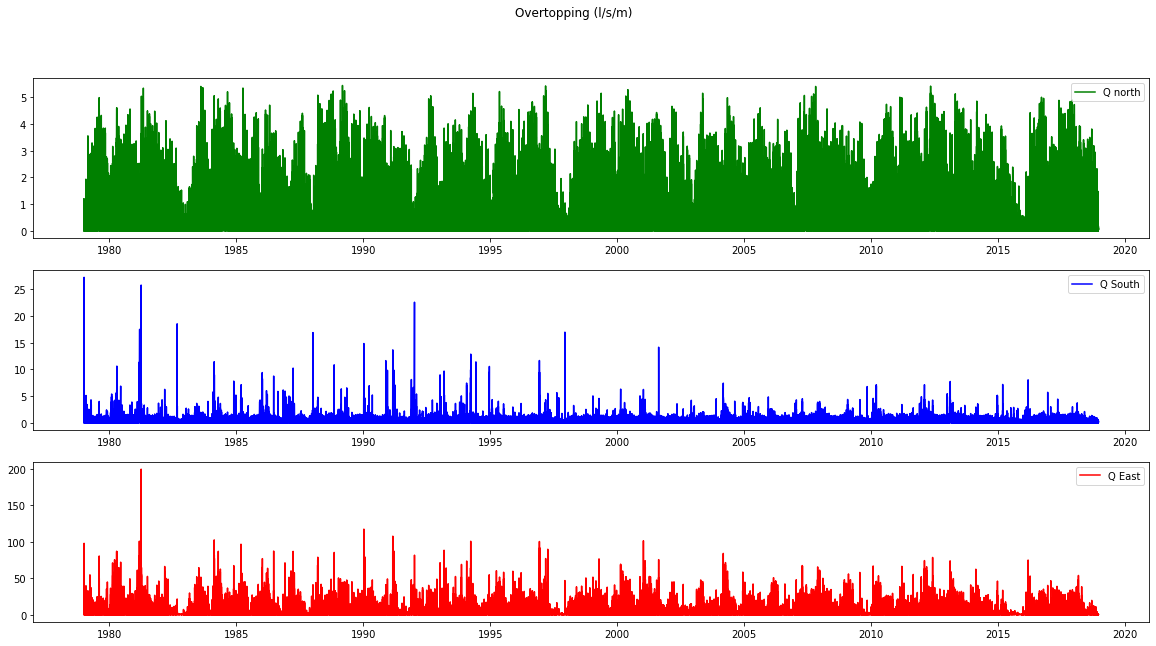

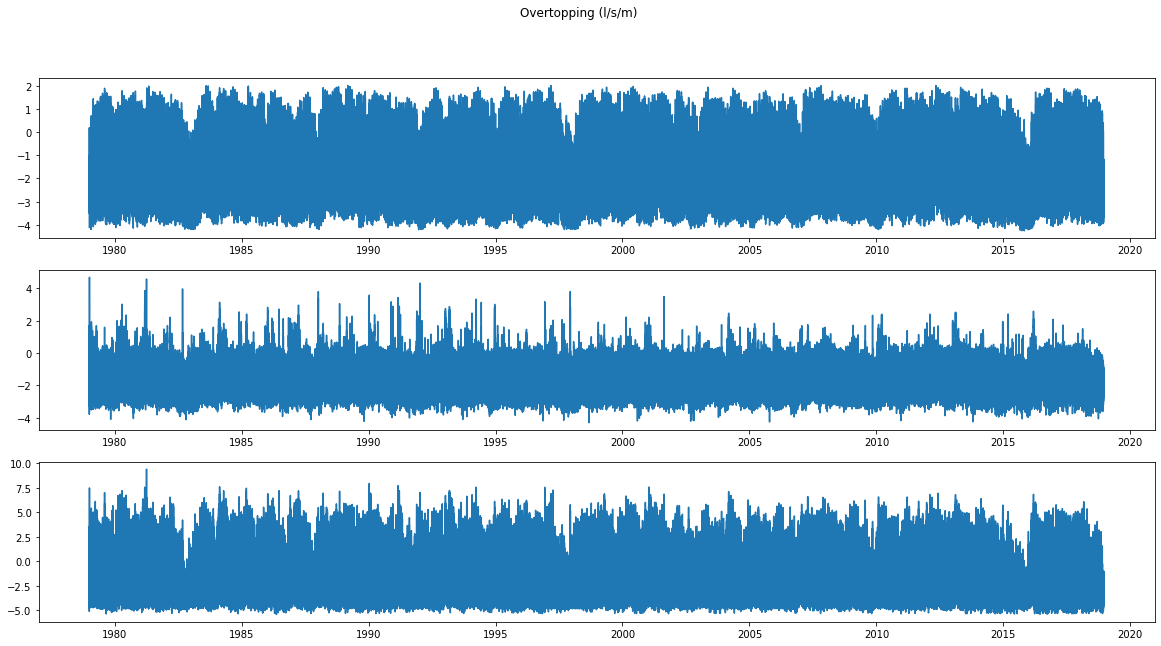

In [10]:
fig, axs = plt.subplots(3,1, figsize=(20,10))

axs[0].plot(out_sim_N.time, out_sim_N.Qinv, color='g', label='Q north')
axs[1].plot(out_sim_S.time, out_sim_S.Qinv, color='b', label='Q South')
axs[2].plot(out_sim_E.time, out_sim_E.Qinv, color='r', label='Q East')
axs[0].legend()
axs[1].legend()
axs[2].legend()
plt.suptitle('Overtopping (l/s/m)')



fig, axs = plt.subplots(3,1, figsize=(20,10))

axs[0].plot(out_sim_N.time, out_sim_N.Q, label='Q north')
axs[1].plot(out_sim_S.time, out_sim_S.Q, label='Q South')
axs[2].plot(out_sim_E.time, out_sim_E.Q, label='Q East')

plt.suptitle('Overtopping (l/s/m)')

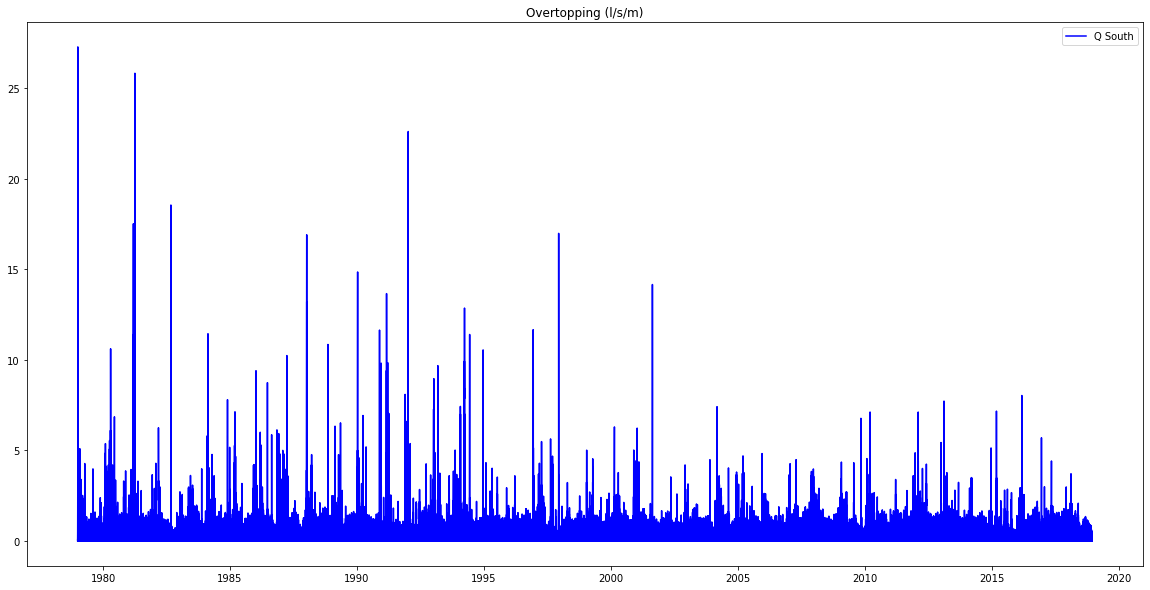

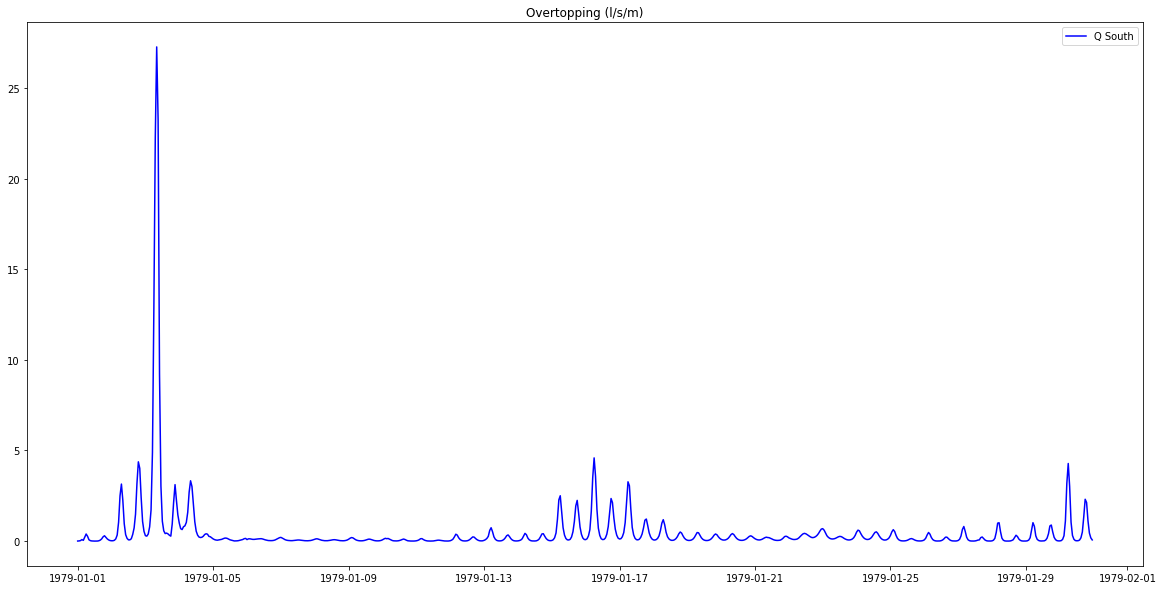

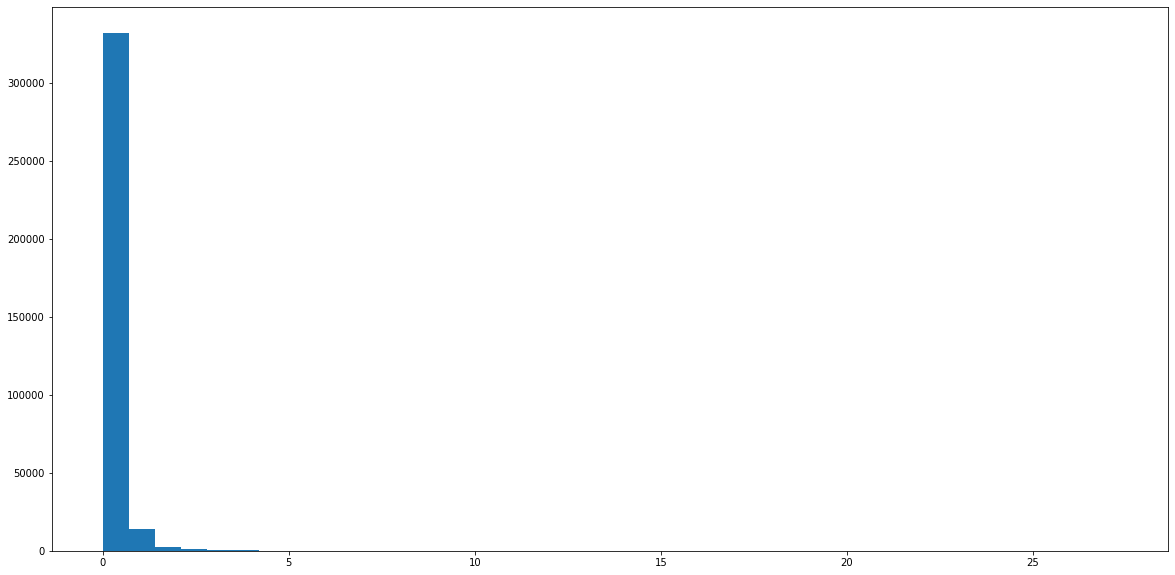

[  0.    2.5   5.    7.5  10.   12.5  15.   17.5  20.   22.5  25.   27.5
  30.   32.5  35.   37.5  40.   42.5  45.   47.5  50.   52.5  55.   57.5
  60.   62.5  65.   67.5  70.   72.5  75.   77.5  80.   82.5  85.   87.5
  90.   92.5  95.   97.5 100. ]

[4.68913209e-05 6.74504255e-03 1.00007025e-02 1.29274470e-02
 1.58361122e-02 1.88275301e-02 2.18918828e-02 2.49772834e-02
 2.82271611e-02 3.15090825e-02 3.48881768e-02 3.82605993e-02
 4.18283836e-02 4.55537691e-02 4.94712051e-02 5.35671333e-02
 5.78837172e-02 6.24485163e-02 6.74239588e-02 7.28202569e-02
 7.86372872e-02 8.52444340e-02 9.23377204e-02 1.00231478e-01
 1.09067464e-01 1.18770654e-01 1.29783202e-01 1.42004474e-01
 1.55707613e-01 1.72011115e-01 1.90123098e-01 2.12093559e-01
 2.38516260e-01 2.71555357e-01 3.13661167e-01 3.69183653e-01
 4.45509895e-01 5.54568322e-01 7.16656648e-01 1.02960369e+00
 2.72642053e+01]


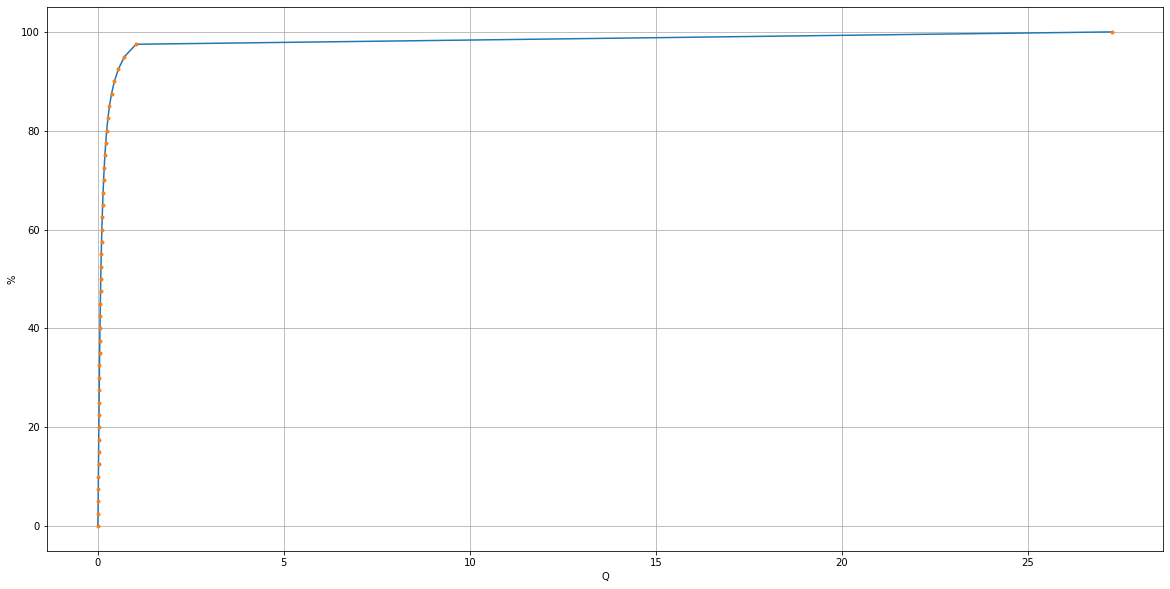

In [11]:
plt.figure(figsize=(20,10))

plt.plot(out_sim_S.time, out_sim_S.Qinv, color='b', label='Q South')
plt.legend()
plt.legend()
plt.title('Overtopping (l/s/m)')


plt.figure(figsize=(20,10))

plt.plot(out_sim_S.time.values[0:24*30], out_sim_S.Qinv.values[0:24*30], color='b', label='Q South')
plt.legend()
plt.legend()
plt.title('Overtopping (l/s/m)')


# histogram
plt.figure(figsize=(20,10))
bins_number = 40 
bins = np.linspace(np.nanmin(out_sim_S.Qinv.values), np.nanmax(out_sim_S.Qinv.values), bins_number)

n, _, _ = plt.hist(out_sim_S.Qinv.values, bins)
plt.show()


# percentiles
q = np.linspace(0,100,41)
perc = np.nanpercentile(out_sim_S.Qinv.values, q)

plt.figure(figsize=(20,10))
plt.plot(perc, q)
plt.plot(perc, q, '.')
plt.xlabel('Q')
plt.ylabel('%')
plt.grid()

print(q)
print()
print(perc)